In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [3]:
model = LogisticRegression(max_iter=5000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [4]:
model = LogisticRegression(max_iter=5000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
X, y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(X, columns=load_breast_cancer().feature_names)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [7]:
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X_train, y_train)
selected_rfe = X.columns[rfe.get_support()]
print("🔹RFE Chosen Features (5):", list(selected_rfe))

model.fit(X_train[selected_rfe], y_train)
y_pred_rfe = model.predict(X_test[selected_rfe])
print(f"🔹Accuracy with RFE (5 features): {accuracy_score(y_test, y_pred_rfe):.4f}\n")

🔹RFE Chosen Features (5): ['mean radius', 'texture error', 'worst radius', 'worst compactness', 'worst concavity']
🔹Accuracy with RFE (5 features): 0.9790



In [8]:
best_score, best_k = 0, 0
for k in range(1, X.shape[1] + 1):
    rfe_k = RFE(estimator=model, n_features_to_select=k)
    score = cross_val_score(rfe_k, X, y, scoring='accuracy', cv=cv).mean()
    if score > best_score:
        best_score = score
        best_k = k
print(f"🔹RFE Auto-Tuned Best k: {best_k} → CV Accuracy: {best_score:.4f}\n")

🔹RFE Auto-Tuned Best k: 21 → CV Accuracy: 0.9561



In [9]:
from sklearn.metrics import make_scorer, balanced_accuracy_score

balanced_scorer = make_scorer(balanced_accuracy_score)
best_bal_score, best_bal_k = 0, 0
for k in range(1, X.shape[1] + 1):
    rfe_k = RFE(estimator=model, n_features_to_select=k)
    score = cross_val_score(rfe_k, X, y, scoring=balanced_scorer, cv=cv).mean()
    if score > best_bal_score:
        best_bal_score = score
        best_bal_k = k
print(f"🔹RFE (Balanced Accuracy): Best k = {best_bal_k} → Balanced CV Acc: {best_bal_score:.4f}\n")


🔹RFE (Balanced Accuracy): Best k = 14 → Balanced CV Acc: 0.9507



In [10]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    min_features_to_select=1
)
rfecv.fit(X_train, y_train)
selected_rfecv = X.columns[rfecv.get_support()]
print("🔹RFECV Chosen Features:", list(selected_rfecv))
print(f"🔹RFECV Optimal Feature Count: {rfecv.n_features_}")

model.fit(X_train[selected_rfecv], y_train)
y_pred_rfecv = model.predict(X_test[selected_rfecv])
print(f"🔹RFECV Accuracy on Test Set: {accuracy_score(y_test, y_pred_rfecv):.4f}\n")


🔹RFECV Chosen Features: ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'texture error', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']
🔹RFECV Optimal Feature Count: 18
🔹RFECV Accuracy on Test Set: 0.9580



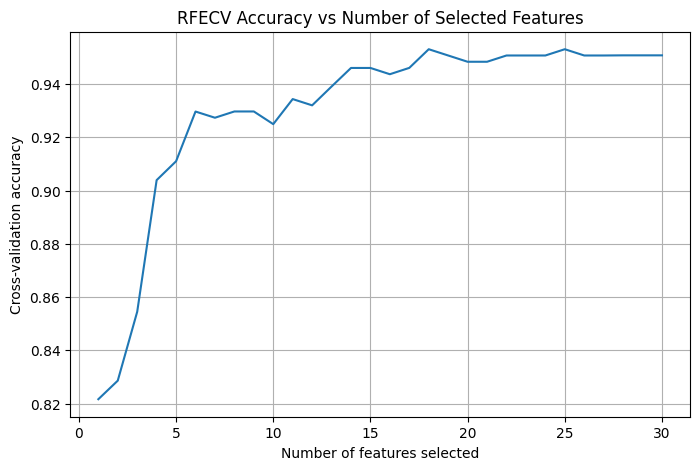

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score']
)
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation accuracy")
plt.title("RFECV Accuracy vs Number of Selected Features")
plt.grid(True)
plt.show()

In [12]:
def apply_rfe_to_iris():
    print("\n🌸 Applying to Iris Dataset:")
    X_iris, y_iris = load_iris(return_X_y=True)
    X_iris = pd.DataFrame(X_iris, columns=load_iris().feature_names)

    # Auto-tune RFE for Iris
    best_score, best_k = 0, 0
    for k in range(1, X_iris.shape[1] + 1):
        rfe = RFE(model, n_features_to_select=k)
        score = cross_val_score(rfe, X_iris, y_iris, scoring='accuracy', cv=cv).mean()
        if score > best_score:
            best_score = score
            best_k = k
    print(f"🔹Best k for Iris: {best_k} → CV Accuracy: {best_score:.4f}")

    # RFECV for Iris
    rfecv_iris = RFECV(model, cv=cv, scoring='accuracy')
    rfecv_iris.fit(X_iris, y_iris)
    selected_feats = X_iris.columns[rfecv_iris.get_support()]
    print("🔹RFECV Selected Features (Iris):", list(selected_feats))

# ✅ Call the function
apply_rfe_to_iris()


🌸 Applying to Iris Dataset:
🔹Best k for Iris: 2 → CV Accuracy: 0.9667
🔹RFECV Selected Features (Iris): ['petal length (cm)', 'petal width (cm)']
